#### Step 1: Setting Up the Environment (Libraries & Data):

##### Setting Up Environment:

In [1]:
# Importing core libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# For visualization and numerical operations
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import copy

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


##### KMNIST Dataset Loading:

In [2]:
# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Download and load training/test data
train_dataset = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Preview dataset size
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

100%|██████████| 18.2M/18.2M [00:14<00:00, 1.30MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 132kB/s]
100%|██████████| 3.04M/3.04M [00:04<00:00, 717kB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 7.87MB/s]

Train dataset size: 60000
Test dataset size: 10000


#### Step 2: Data Preparation (Including 5-Fold Cross-Validation):

##### Code to Prepare 5-Fold Cross-Validation:

In [3]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

# Number of folds
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# This will give us 5 different train/val splits
splits = list(kfold.split(train_dataset))

# Displaying one fold split for understanding
for fold, (train_idx, val_idx) in enumerate(splits):
    print(f"Fold {fold + 1}:")
    print(f"Train indices: {train_idx[:5]}...")
    print(f"Validation indices: {val_idx[:5]}...")
    break  # Just show one fold example

Fold 1:
Train indices: [0 1 2 3 5]...
Validation indices: [ 4  6  7 32 34]...


##### Function to Create Dataloaders for a Given Fold:

In [4]:
def get_dataloaders_for_fold(fold_index, batch_size=64):
    train_idx, val_idx = splits[fold_index]

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

##### Example Usage for Fold 0:

In [5]:
# Create dataloaders for the first fold
train_loader, val_loader, test_loader = get_dataloaders_for_fold(0)

# Check a sample batch
images, labels = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

Image batch shape: torch.Size([64, 1, 28, 28])
Label batch shape: torch.Size([64])


#### Step 3: Define the Neural Network

##### Model Code:

In [6]:
class FeedforwardNN(nn.Module):
    def __init__(self):
        super(FeedforwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)  # 10 classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)  # No softmax here; CrossEntropyLoss handles it
        return x

##### Instantiating Model and Moving to Device:

In [7]:
model = FeedforwardNN().to(device)
print(model)

FeedforwardNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


#### Step 4: Training and Evaluation Framework:

#### Defining the Loss Function:

In [8]:
criterion = nn.CrossEntropyLoss()

##### Defining Accuracy Function:

In [9]:
def compute_accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == labels).sum().item()
    return correct / len(labels)

##### Training and Validation Loop:

In [10]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc


def evaluate(model, loader):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc

##### Full Training Procedure per Fold & Optimizer:

In [11]:
def train_model_for_optimizer(optimizer_name, fold_index, num_epochs=10, batch_size=64):
    train_loader, val_loader, test_loader = get_dataloaders_for_fold(fold_index, batch_size=batch_size)

    model = FeedforwardNN().to(device)

    if optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters())
    elif optimizer_name == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters())
    elif optimizer_name == 'adamw':
        optimizer = optim.AdamW(model.parameters())
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        val_loss, val_acc = evaluate(model, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"[{optimizer_name.upper()} | Fold {fold_index+1} | Epoch {epoch+1}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    total_time = time.time() - start_time
    return model, train_losses, val_losses, train_accs, val_accs, total_time, test_loader

In [12]:
model, train_losses, val_losses, train_accs, val_accs, total_time, test_loader = train_model_for_optimizer(
    optimizer_name='adam',
    fold_index=0,
    num_epochs=10,  # You can adjust this
    batch_size=64
)

[ADAM | Fold 1 | Epoch 1] Train Loss: 0.5435, Train Acc: 0.8316 | Val Loss: 0.3285, Val Acc: 0.8972
[ADAM | Fold 1 | Epoch 2] Train Loss: 0.2713, Train Acc: 0.9169 | Val Loss: 0.2478, Val Acc: 0.9213
[ADAM | Fold 1 | Epoch 3] Train Loss: 0.1990, Train Acc: 0.9384 | Val Loss: 0.2204, Val Acc: 0.9325
[ADAM | Fold 1 | Epoch 4] Train Loss: 0.1549, Train Acc: 0.9517 | Val Loss: 0.1991, Val Acc: 0.9417
[ADAM | Fold 1 | Epoch 5] Train Loss: 0.1304, Train Acc: 0.9586 | Val Loss: 0.1799, Val Acc: 0.9453
[ADAM | Fold 1 | Epoch 6] Train Loss: 0.1055, Train Acc: 0.9670 | Val Loss: 0.1780, Val Acc: 0.9497
[ADAM | Fold 1 | Epoch 7] Train Loss: 0.0905, Train Acc: 0.9711 | Val Loss: 0.1975, Val Acc: 0.9433
[ADAM | Fold 1 | Epoch 8] Train Loss: 0.0765, Train Acc: 0.9761 | Val Loss: 0.1934, Val Acc: 0.9483
[ADAM | Fold 1 | Epoch 9] Train Loss: 0.0651, Train Acc: 0.9790 | Val Loss: 0.1999, Val Acc: 0.9474
[ADAM | Fold 1 | Epoch 10] Train Loss: 0.0586, Train Acc: 0.9801 | Val Loss: 0.2456, Val Acc: 0.9387

#### Step 5: Cross-Validation Loop for All Optimizers:

##### Define Optimizer Evaluation Function:

In [13]:
def run_cross_validation(optimizer_name, num_epochs=10, batch_size=64):
    print(f"\n=== Running 5-Fold Cross-Validation with {optimizer_name.upper()} ===")
    all_train_acc = []
    all_val_acc = []
    all_train_loss = []
    all_val_loss = []
    total_training_time = 0

    for fold_index in range(k_folds):
        print(f"\n---- Fold {fold_index + 1} ----")
        model, train_losses, val_losses, train_accs, val_accs, train_time, _ = train_model_for_optimizer(
            optimizer_name, fold_index, num_epochs, batch_size
        )
        all_train_acc.append(train_accs[-1])
        all_val_acc.append(val_accs[-1])
        all_train_loss.append(train_losses[-1])
        all_val_loss.append(val_losses[-1])
        total_training_time += train_time

    # Average metrics over all folds
    avg_train_acc = np.mean(all_train_acc)
    avg_val_acc = np.mean(all_val_acc)
    avg_train_loss = np.mean(all_train_loss)
    avg_val_loss = np.mean(all_val_loss)

    print(f"\n=== {optimizer_name.upper()} Results (5-Fold Avg) ===")
    print(f"Train Accuracy: {avg_train_acc:.4f}")
    print(f"Validation Accuracy: {avg_val_acc:.4f}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Total Training Time: {total_training_time:.2f} seconds")

    return {
        'optimizer': optimizer_name,
        'train_acc': avg_train_acc,
        'val_acc': avg_val_acc,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'time': total_training_time
    }

##### Running All 3 Optimizers:

In [14]:
results = []
for opt in ['adam', 'rmsprop', 'adamw']:
    result = run_cross_validation(opt, num_epochs=10, batch_size=64)
    results.append(result)


=== Running 5-Fold Cross-Validation with ADAM ===

---- Fold 1 ----
[ADAM | Fold 1 | Epoch 1] Train Loss: 0.5546, Train Acc: 0.8278 | Val Loss: 0.3301, Val Acc: 0.8967
[ADAM | Fold 1 | Epoch 2] Train Loss: 0.2689, Train Acc: 0.9164 | Val Loss: 0.2493, Val Acc: 0.9186
[ADAM | Fold 1 | Epoch 3] Train Loss: 0.2016, Train Acc: 0.9377 | Val Loss: 0.2112, Val Acc: 0.9308
[ADAM | Fold 1 | Epoch 4] Train Loss: 0.1589, Train Acc: 0.9510 | Val Loss: 0.1906, Val Acc: 0.9433
[ADAM | Fold 1 | Epoch 5] Train Loss: 0.1296, Train Acc: 0.9595 | Val Loss: 0.1925, Val Acc: 0.9421
[ADAM | Fold 1 | Epoch 6] Train Loss: 0.1093, Train Acc: 0.9654 | Val Loss: 0.1814, Val Acc: 0.9477
[ADAM | Fold 1 | Epoch 7] Train Loss: 0.0922, Train Acc: 0.9700 | Val Loss: 0.1946, Val Acc: 0.9441
[ADAM | Fold 1 | Epoch 8] Train Loss: 0.0785, Train Acc: 0.9750 | Val Loss: 0.2130, Val Acc: 0.9395
[ADAM | Fold 1 | Epoch 9] Train Loss: 0.0695, Train Acc: 0.9771 | Val Loss: 0.2057, Val Acc: 0.9466
[ADAM | Fold 1 | Epoch 10] Trai

#### Step 6: Visualization & Reporting:

##### Converting to DataFrame:

In [15]:
df_results = pd.DataFrame(results)
df_results['optimizer'] = df_results['optimizer'].str.upper()
print(df_results)

  optimizer  train_acc   val_acc  train_loss  val_loss        time
0      ADAM   0.979942  0.945750    0.060894  0.219690  616.282012
1   RMSPROP   0.913658  0.897733    0.327239  0.457175  616.760133
2     ADAMW   0.979975  0.945367    0.061874  0.218000  614.824464


##### Bar Charts:

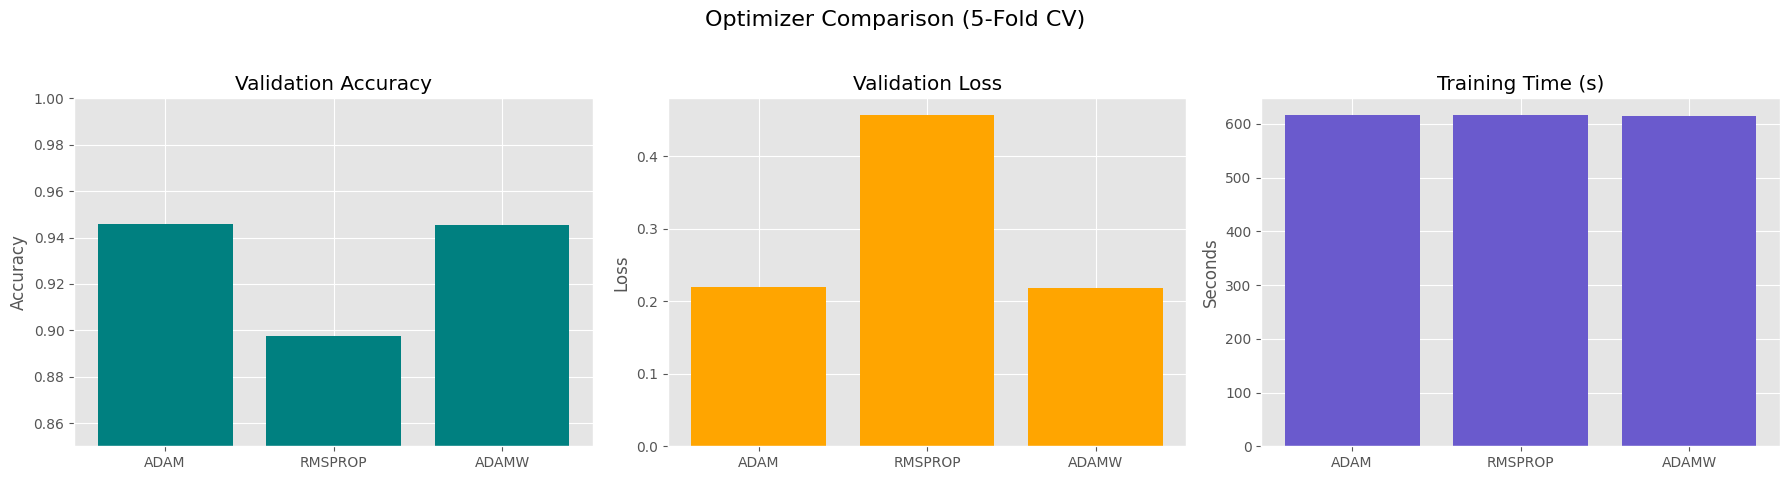

In [16]:
# Set plotting style
plt.style.use("ggplot")
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy plot
axs[0].bar(df_results['optimizer'], df_results['val_acc'], color='teal')
axs[0].set_title("Validation Accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].set_ylim(0.85, 1.0)

# Loss plot
axs[1].bar(df_results['optimizer'], df_results['val_loss'], color='orange')
axs[1].set_title("Validation Loss")
axs[1].set_ylabel("Loss")

# Time plot
axs[2].bar(df_results['optimizer'], df_results['time'], color='slateblue')
axs[2].set_title("Training Time (s)")
axs[2].set_ylabel("Seconds")

plt.suptitle("Optimizer Comparison (5-Fold CV)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [17]:
df_results.to_csv("optimizer_comparison_results.csv", index=False)

In [18]:

from itertools import product

# Define search space
optimizers = ['Adam', 'RMSprop', 'AdamW']
learning_rates = [0.01, 0.001]
batch_sizes = [64, 128]

results = []

def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Perform grid search
for opt_name, lr, batch_size in product(optimizers, learning_rates, batch_sizes):
    fold_accuracies = []

    for fold in range(k_folds):
        train_loader, val_loader, _ = get_dataloaders_for_fold(fold, batch_size=batch_size)

        model = FeedforwardNN().to(device)
        criterion = nn.CrossEntropyLoss()

        if opt_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif opt_name == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=lr)
        elif opt_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=lr)

        val_accuracy = train_and_validate(model, train_loader, val_loader, optimizer, criterion)
        fold_accuracies.append(val_accuracy)

    avg_acc = sum(fold_accuracies) / len(fold_accuracies)
    results.append((opt_name, lr, batch_size, avg_acc))

# Sort and display best config
results.sort(key=lambda x: x[-1], reverse=True)
print("Best configuration found:")
print(f"Optimizer: {results[0][0]}, Learning Rate: {results[0][1]}, Batch Size: {results[0][2]}, Avg Accuracy: {results[0][3]:.4f}")


Best configuration found:
Optimizer: RMSprop, Learning Rate: 0.001, Batch Size: 64, Avg Accuracy: 0.9423
